In [1]:
import numpy as np
import pandas as pd
import sys
import scipy
import copy
from scipy.optimize import curve_fit
from scipy.stats import unitary_group
import time as t
import matplotlib.pyplot as plt
np.set_printoptions(precision=2, linewidth=100)


In [21]:
players = 10
baseCurve = .02 #learning fraction
weightInit = 1000

lenderCollatValueRatio = 1.1
renterCollatValueRatio = 3
paymentFraction = .5

expectationCost = .01
beta = .5
def utilityFunction(delta,beta):
    return .5*np.tanh(delta*beta)

def depthCurve(depth):
    #return np.tanh((depth+1)*.1)
    return 1

def greedFunc(util):
    return -.5*util*np.tanh(util)
    #return 0

class DecisionTree():
    def __init__(self, data = None):
        self.nodes = []
        self.data = data
        
#results functions
def applyResult(renterStrat, lenderStrat, path, renterUtilDelta, lenderUtilDelta, goodEnding = -1):
    rtemp = renterUtilDelta
    ltemp = lenderUtilDelta
    renterUtilDelta += greedFunc(ltemp) - renterUtilDelta*expectationCost*goodEnding
    lenderUtilDelta += greedFunc(rtemp) - lenderUtilDelta*expectationCost*goodEnding
    renterStrat.runningTotal += renterUtilDelta
    lenderStrat.runningTotal += lenderUtilDelta
    currNodeR = renterStrat.weightsList.nodes[0]
    currNodeL = lenderStrat.weightsList.nodes[0]
    depth = 0
    for index in path:
        if depth==0:
            depth+=1
            continue
        if currNodeR.data[0] == "renter":
            currNodeR.nodes[index].data[-1] += currNodeR.nodes[index].data[-1]*renterStrat.curve*renterUtilDelta*depthCurve(depth)
        if currNodeL.data[0] == "lender":
            currNodeL.nodes[index].data[-1] += currNodeL.nodes[index].data[-1]*lenderStrat.curve*lenderUtilDelta*depthCurve(depth)
        currNodeR = currNodeR.nodes[index]
        currNodeL = currNodeL.nodes[index]
        depth += 1
    

def blameRenterRecievedBad(renterStrat, lenderStrat, path):
    renterUtilDelta = utilityFunction(-(renterCollatValueRatio + paymentFraction),beta)
    lenderUtilDelta = utilityFunction(-(lenderCollatValueRatio),beta)
    applyResult(renterStrat, lenderStrat, path, renterUtilDelta, lenderUtilDelta)
        
def abortCouldntGiveGood(renterStrat, lenderStrat, path):
    renterUtilDelta = utilityFunction(0,beta)
    lenderUtilDelta = utilityFunction(0,beta)
    applyResult(renterStrat, lenderStrat, path, renterUtilDelta, lenderUtilDelta)
        
def abortTimeoutGiving(renterStrat, lenderStrat, path):
    renterUtilDelta = utilityFunction(0,beta)
    lenderUtilDelta = utilityFunction(0,beta)
    applyResult(renterStrat, lenderStrat, path, renterUtilDelta, lenderUtilDelta)
        
def blameRenterRecievedGood(renterStrat, lenderStrat, path):
    renterUtilDelta = utilityFunction(-(renterCollatValueRatio + paymentFraction) + 1,beta)
    lenderUtilDelta = utilityFunction(-(lenderCollatValueRatio + 1),beta)
    applyResult(renterStrat, lenderStrat, path, renterUtilDelta, lenderUtilDelta)
        
def abortCouldntGiveBad(renterStrat, lenderStrat, path):
    renterUtilDelta = utilityFunction(1,beta)
    lenderUtilDelta = utilityFunction(-1,beta)
    applyResult(renterStrat, lenderStrat, path, renterUtilDelta, lenderUtilDelta)
        
def abortTimeoutForcePurchase(renterStrat, lenderStrat, path):
    renterUtilDelta = utilityFunction(-lenderCollatValueRatio-paymentFraction+1,beta)
    lenderUtilDelta = utilityFunction(-1+lenderCollatValueRatio-paymentFraction,beta)
    applyResult(renterStrat, lenderStrat, path, renterUtilDelta, lenderUtilDelta)
        
def blameFalseReturnGood(renterStrat, lenderStrat, path):
    renterUtilDelta = utilityFunction(1-renterCollatValueRatio,beta)
    lenderUtilDelta = utilityFunction(-lenderCollatValueRatio,beta)
    applyResult(renterStrat, lenderStrat, path, renterUtilDelta, lenderUtilDelta)
        
def FinalizeBad(renterStrat, lenderStrat, path):
    renterUtilDelta = utilityFunction(1,beta)
    lenderUtilDelta = utilityFunction(-1+paymentFraction,beta)
    applyResult(renterStrat, lenderStrat, path, renterUtilDelta, lenderUtilDelta)
        
def blameFalseReturnBad(renterStrat, lenderStrat, path):
    renterUtilDelta = utilityFunction(-renterCollatValueRatio,beta)
    lenderUtilDelta = utilityFunction(-lenderCollatValueRatio,beta)
    applyResult(renterStrat, lenderStrat, path, renterUtilDelta, lenderUtilDelta)
        
def FinalizeGood(renterStrat, lenderStrat, path):
    renterUtilDelta = utilityFunction(0,beta)
    lenderUtilDelta = utilityFunction(paymentFraction,beta)
    applyResult(renterStrat, lenderStrat, path, renterUtilDelta, lenderUtilDelta, -1)
    
#define the decision tree of the game
TreeRoot = DecisionTree(["lender","creation -> funding -> giving",weightInit])
#TreeRoot.nodes.append(DecisionTree(["renter","lender cheat give",weightInit]))
#TreeRoot.nodes[0].nodes.append(DecisionTree(["lender","lender cheat give",weightInit]))
#TreeRoot.nodes[0].nodes[0].nodes.append(DecisionTree(["exit",blameCannotGiveBad,weightInit]))
#TreeRoot.nodes[0].nodes[0].nodes.append(DecisionTree(["exit",blameRenterRecievedBad,weightInit]))
#TreeRoot.nodes[0].nodes[0].nodes.append(DecisionTree(["exit",abortCouldntGiveGood,weightInit]))
TreeRoot.nodes.append(DecisionTree(["renter","lender truth give",weightInit]))
TreeRoot.nodes[0].nodes.append(DecisionTree(["lender","renter cheat get",weightInit]))
#TreeRoot.nodes[0].nodes[0].nodes.append(DecisionTree(["exit",blameCannotGiveWorse,weightInit]))
TreeRoot.nodes[0].nodes[0].nodes.append(DecisionTree(["exit",blameRenterRecievedGood,weightInit]))
TreeRoot.nodes[0].nodes[0].nodes.append(DecisionTree(["exit",abortCouldntGiveBad,weightInit]))
TreeRoot.nodes[0].nodes.append(DecisionTree(["lender","renter truth get",weightInit]))
TreeRoot.nodes[0].nodes[1].nodes.append(DecisionTree(["renter","lender try to return",weightInit]))
TreeRoot.nodes[0].nodes[1].nodes[0].nodes.append(DecisionTree(["lender","renter cheat",weightInit]))
TreeRoot.nodes[0].nodes[1].nodes[0].nodes[0].nodes.append(DecisionTree(["exit",blameFalseReturnGood,weightInit]))
TreeRoot.nodes[0].nodes[1].nodes[0].nodes[0].nodes.append(DecisionTree(["exit",FinalizeBad,weightInit]))
TreeRoot.nodes[0].nodes[1].nodes[0].nodes.append(DecisionTree(["lender","renter truth",weightInit]))
#TreeRoot.nodes[0].nodes[1].nodes[0].nodes[1].nodes.append(DecisionTree(["exit",blameFalseReturnBad,weightInit]))
TreeRoot.nodes[0].nodes[1].nodes[0].nodes[1].nodes.append(DecisionTree(["exit",FinalizeGood,weightInit]))
#TreeRoot.nodes[0].nodes[1].nodes[0].nodes.append(DecisionTree(["exit",abortTimeoutForcePurchase,weightInit]))
#TreeRoot.nodes[0].nodes[1].nodes.append(DecisionTree(["exit",abortTimeoutForcePurchase,weightInit]))
#TreeRoot.nodes.append(DecisionTree(["exit",abortTimeoutGiving,weightInit]))
#TreeRoot.nodes.append(DecisionTree(["exit",blameRenterRecievedBad,weightInit]))
#TreeRoot.nodes.append(DecisionTree(["exit",abortCouldntGiveGood,weightInit]))
    
# def getNode(depth, tree):
#     if depth == 0:
#         return tree
#     else:
#         [getNode(depth-1, node) for node in tree.nodes]

def printTree(tree, depth=0, exclude=""):
    if tree.data[0] != exclude:
        print("depth " + str(depth))
        print(tree.data)
    for node in tree.nodes:
        printTree(node,depth+1,exclude)
        
class LenderStrategy():
    def __init__(self,curve = 5):
        self.weightsList = copy.deepcopy(TreeRoot)
        self.curve = curve
        self.runningTotal = 0
        
class RenterStrategy():
    def __init__(self,curve = 5):
        self.weightsList = copy.deepcopy(TreeRoot)
        self.curve = curve
        self.runningTotal = 0

def gameStep(weights, node):
    choicelist = [i for i in range(len(weights)) for j in range(int(np.floor(weights[i])))]
    choice = np.random.choice(choicelist)
    return (node.nodes[choice],choice)
        
def playGame(renterStrat, lenderStrat):
    lenderNode = copy.deepcopy(lenderStrat.weightsList)
    renterNode = copy.deepcopy(renterStrat.weightsList)
    path = []
    depth = 0
    while(True):
        if lenderNode.data[0] == "lender":
            weights = [node.data[-1] for node in lenderNode.nodes]
            (lenderNode, pathChosen) = gameStep(weights, lenderNode)
            renterNode = renterNode.nodes[pathChosen]
            path.append(pathChosen)
            depth += 1
            continue
        if renterNode.data[0] == "renter":
            weights = [node.data[-1] for node in renterNode.nodes]
            (renterNode, pathChosen) = gameStep(weights, renterNode)
            lenderNode = lenderNode.nodes[pathChosen]
            path.append(pathChosen)
            depth += 1
            continue
        if lenderNode.data[0] == "exit":
            lenderNode.data[1](renterStrat, lenderStrat, path)
            break
        print("reached error state, bad tree")
        break
    return str(lenderNode.data[1])

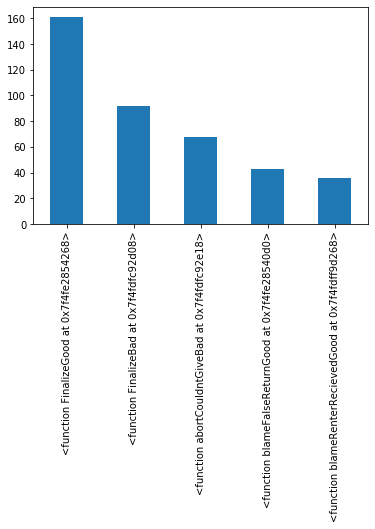

In [22]:
#takes a sec be patient

testRenter = RenterStrategy(baseCurve)
testLender = LenderStrategy(baseCurve)

outcomes = [playGame(testRenter,testLender) for i in range(4000)]

pd.Series(outcomes[-400:]).value_counts().plot.bar()

In [23]:
print("renter")
print("running total is " + str(testRenter.runningTotal))
printTree(testRenter.weightsList,exclude="")
print("\nlender")
print("running total is " + str(testLender.runningTotal))
printTree(testLender.weightsList,exclude="")

renter
running total is -125.43846209693581
depth 0
['lender', 'creation -> funding -> giving', 1000]
depth 1
['renter', 'lender truth give', 1000]
depth 2
['lender', 'renter cheat get', 160.5050527019234]
depth 3
['exit', <function blameRenterRecievedGood at 0x7f4fdff9d268>, 1000]
depth 3
['exit', <function abortCouldntGiveBad at 0x7f4fdfc92e18>, 1000]
depth 2
['lender', 'renter truth get', 479.02906875095573]
depth 3
['renter', 'lender try to return', 1000]
depth 4
['lender', 'renter cheat', 596.7960212211738]
depth 5
['exit', <function blameFalseReturnGood at 0x7f4fe28540d0>, 1000]
depth 5
['exit', <function FinalizeBad at 0x7f4fdfc92d08>, 1000]
depth 4
['lender', 'renter truth', 802.6679999822373]
depth 5
['exit', <function FinalizeGood at 0x7f4fe2854268>, 1000]

lender
running total is -542.715362693984
depth 0
['lender', 'creation -> funding -> giving', 1000]
depth 1
['renter', 'lender truth give', 1000]
depth 2
['lender', 'renter cheat get', 1000]
depth 3
['exit', <function blam